In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from glob import glob
from sklearn.metrics import (
    auc,
    precision_recall_curve,
    roc_curve,
)
import numpy as np
lab_dict = {"neut": 0, "ssv": 1, "sdn": 2}


In [2]:
def get_roc(data):
    """Plot ROC curve by binarizing neutral/sweep."""

    # Plot sdn/ssv distinction
    sweep_idxs = np.transpose(np.array((data["int_true"] > 0)).nonzero())
    sweep_labs = np.array(data["int_true"])[sweep_idxs]

    sdn_probs = data[data["int_true"] > 0]["sdn_prob"]

    swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=2)
    swp_auc_val = auc(swp_fpr, swp_tpr)

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["int_true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot ROC Curve
    fpr, tpr, thresh = roc_curve(labs, pred_probs)
    auc_val = auc(fpr, tpr)
    return fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val


def get_prec_recall(data):
    """Plot PR curve by binarizing neutral/sweep."""
    # Plot sdn/ssv distinction

    filt_data = data[(data["sdn_prob"] > 0.0) & (data["ssv_prob"] > 0.0)]

    sweep_idxs = np.transpose(np.array((filt_data["int_true"] > 0)).nonzero())
    sweep_labs = np.array(filt_data["int_true"])[sweep_idxs]

    # TODO FIX THIS: divide score of sweep by summed sweep prob
    # TODO FIlter out where probs of both prob are 0
    if len(np.unique(filt_data["int_true"])) > 2:
        sdn_probs = filt_data[filt_data["int_true"] > 0]["sdn_prob"] / (
            filt_data[filt_data["int_true"] > 0]["sdn_prob"]
            + filt_data[filt_data["int_true"] > 0]["ssv_prob"]
        )

        swp_prec, swp_rec, swp_thresh = precision_recall_curve(
            sweep_labs.flatten(), sdn_probs, pos_label=2
        )
        swp_auc_val = auc(swp_rec, swp_prec)

    # Coerce all ssvs into sweep binary pred
    labs = np.array(data["int_true"])
    labs[labs > 1] = 1
    pred_probs = np.sum(np.array([data["sdn_prob"], data["ssv_prob"]]).T, axis=1)

    # Plot PR Curve for binarized labs
    prec, rec, thresh = precision_recall_curve(labs, pred_probs)
    auc_val = auc(rec, prec)
    return prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val

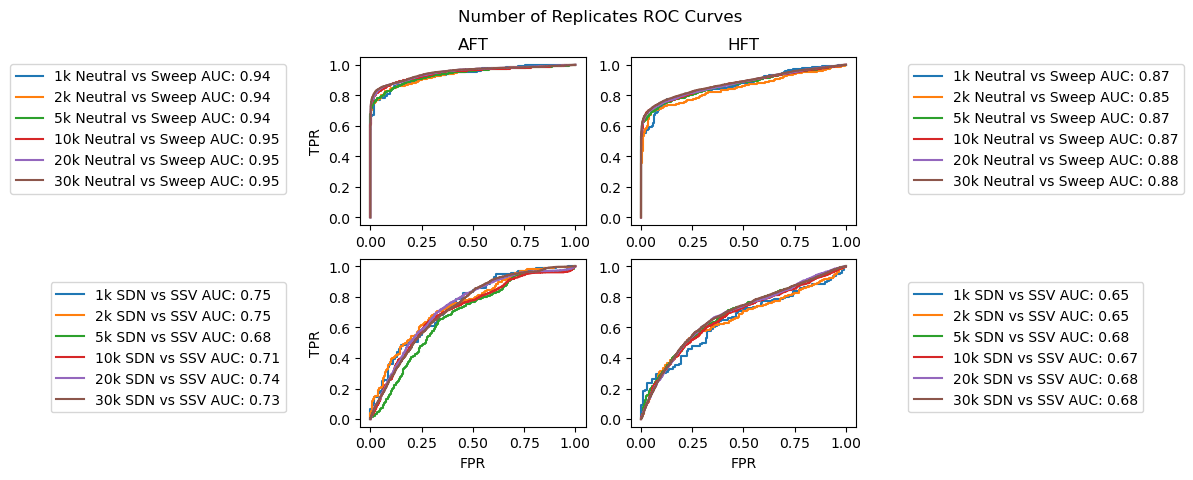

In [39]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/num_replicates/num_replicates/test_predictions"
names = [f"{i}k" for i in [1, 2, 5, 10, 20, 30]]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name in names:
        df = pd.read_csv(f"{idir}/Reps_Size_{name}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"{name} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"{name} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))
plt.suptitle("Number of Replicates ROC Curves")
plt.savefig("num_reps_roc.pdf", bbox_inches="tight")


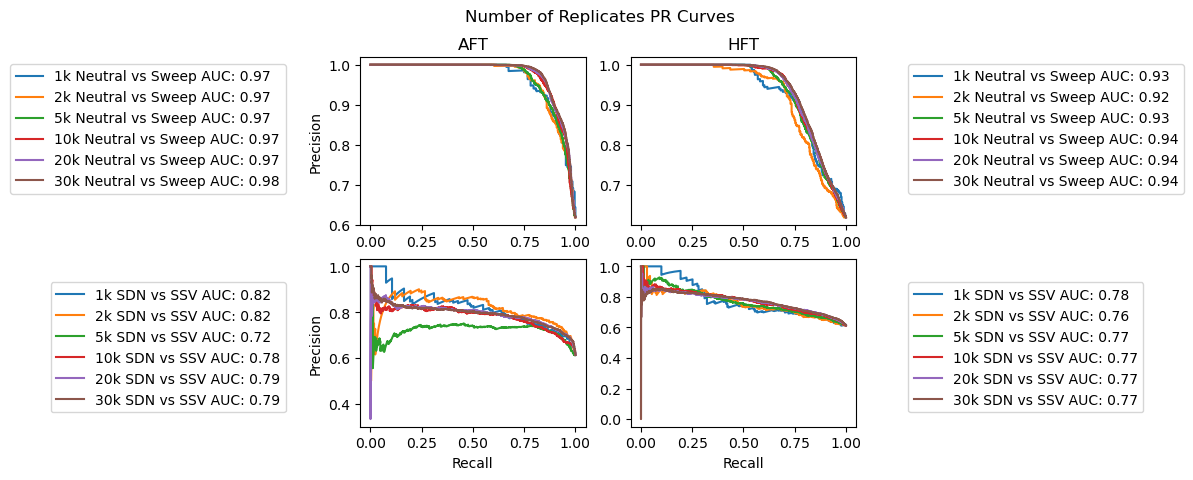

In [40]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/num_replicates/num_replicates/test_predictions"
names = [f"{i}k" for i in [1, 2, 5, 10, 20, 30]]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name in names:
        df = pd.read_csv(f"{idir}/Reps_Size_{name}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"{name} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"{name} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))
plt.suptitle("Number of Replicates PR Curves")
plt.savefig("num_reps_pr.pdf", bbox_inches="tight")


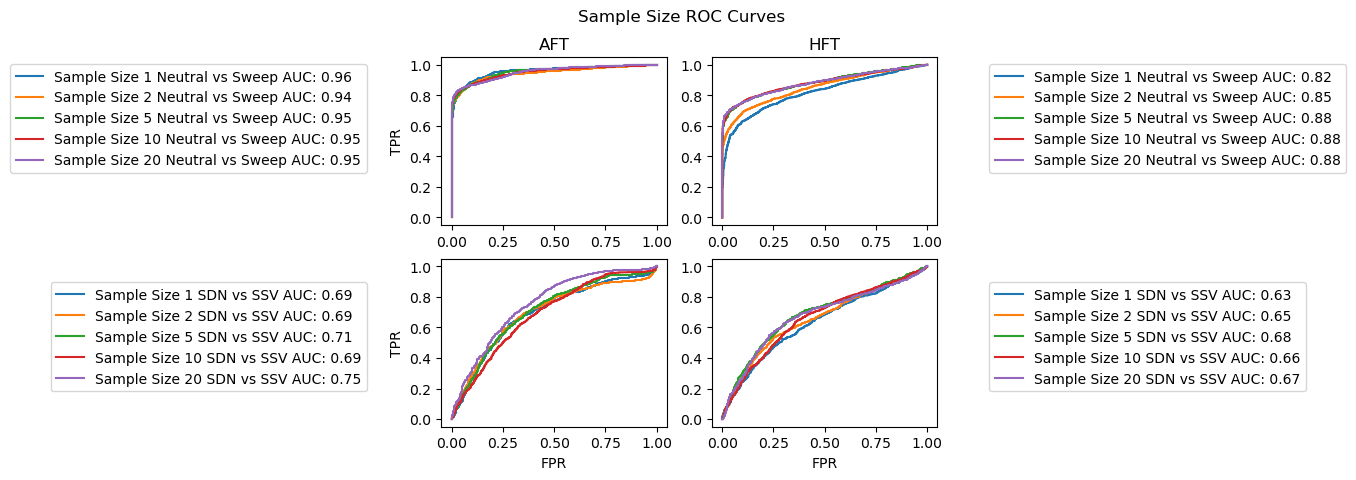

In [41]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sample_size"
nums = [1, 2, 5, 10, 20]
names = [f"ss_{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/samp_size_sims/test_predictions/Sample_Size_{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"Sample Size {num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"Sample Size {num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Sample Size ROC Curves")
plt.savefig("samp_size_roc.pdf", bbox_inches="tight")

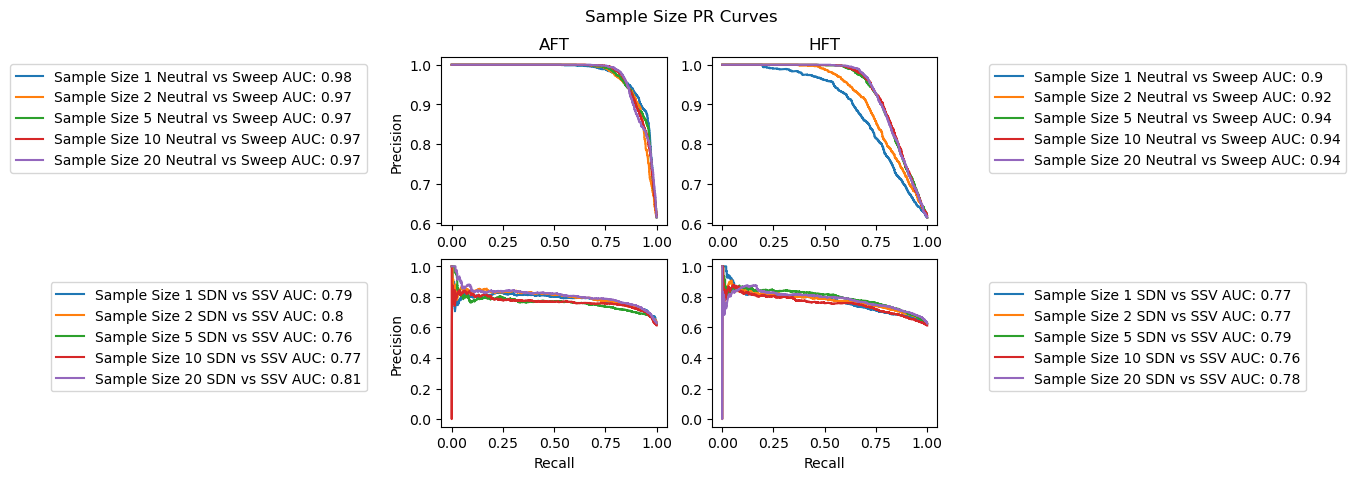

In [42]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sample_size"
nums = [1, 2, 5, 10, 20]
names = [f"ss_{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/samp_size_sims/test_predictions/Sample_Size_{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"Sample Size {num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"Sample Size {num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Sample Size PR Curves")
plt.savefig("sample_size_pr.pdf", bbox_inches="tight")

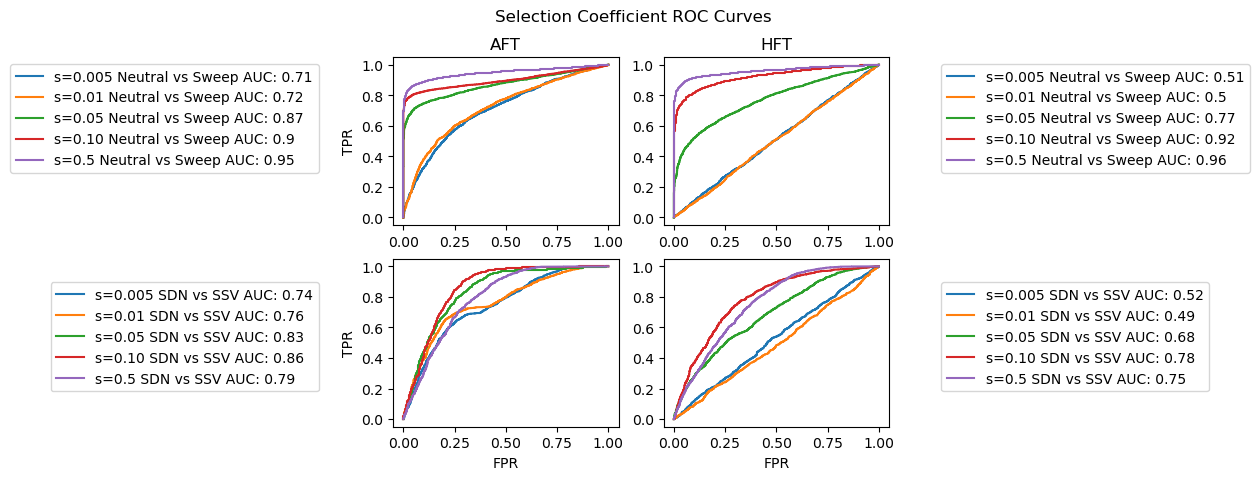

In [43]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sel_coeff"
nums = ["005", "01", "05", "10", "5"]
names = [f"s_{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/0.{num}_selcoeff/test_predictions/Sel_Coeff_0.{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"s=0.{num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"s=0.{num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")
    
axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Selection Coefficient ROC Curves")
plt.savefig("sel_coeff_roc.pdf", bbox_inches="tight")

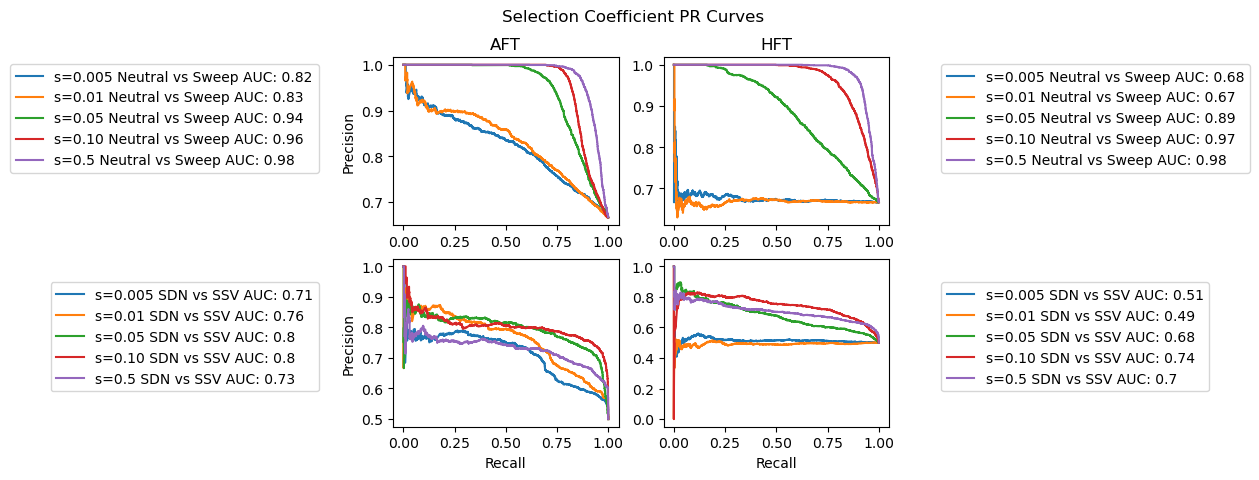

In [44]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sel_coeff"
nums = ["005", "01", "05", "10", "5"]
names = [f"s_{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/0.{num}_selcoeff/test_predictions/Sel_Coeff_0.{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"s=0.{num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"s=0.{num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Selection Coefficient PR Curves")
plt.savefig("sel_coeff_pr.pdf", bbox_inches="tight")

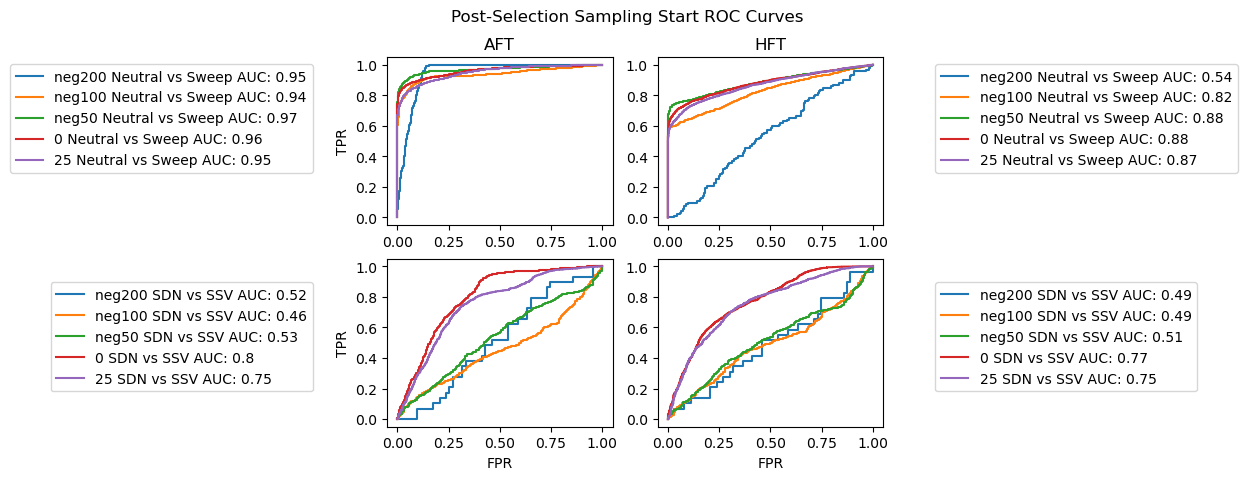

In [45]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sel_timing"
nums = ["neg200", "neg100", "neg50", "0", "25", "50", "100", "200"]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{num}_gens/{num}gens/test_predictions/{num}_Gens_Post_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"{num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"{num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")
    
axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Post-Selection Sampling Start ROC Curves")
plt.savefig("sel_timing_roc.pdf", bbox_inches="tight")

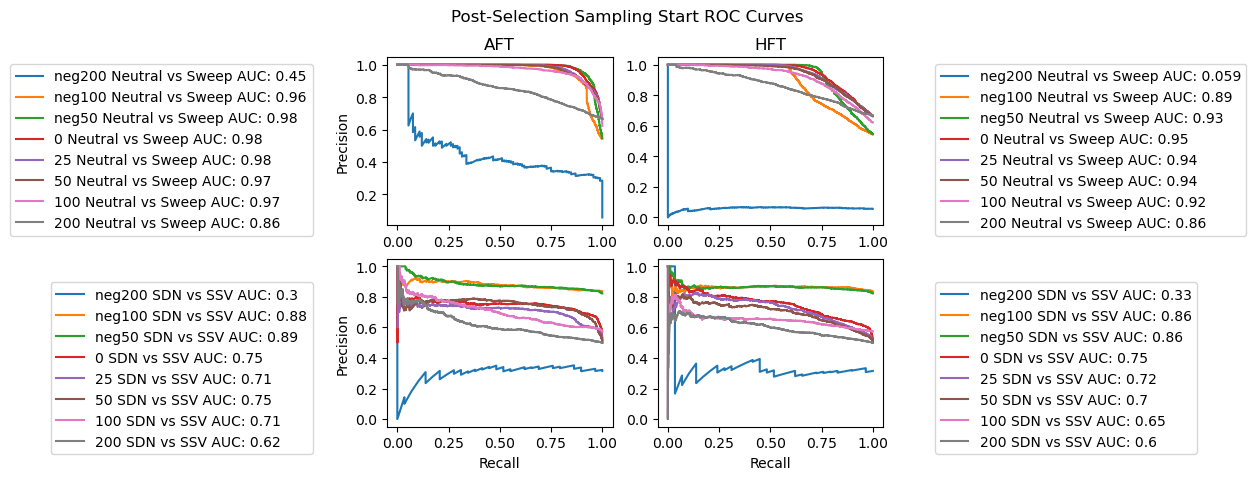

In [46]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/sel_timing"
nums = ["neg200", "neg100", "neg50", "0", "25", "50", "100", "200"]
names = [f"s_{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{num}_gens/{num}gens/test_predictions/{num}_Gens_Post_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"{num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"{num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Post-Selection Sampling Start ROC Curves")
plt.savefig("sel_timing_pr.pdf", bbox_inches="tight")

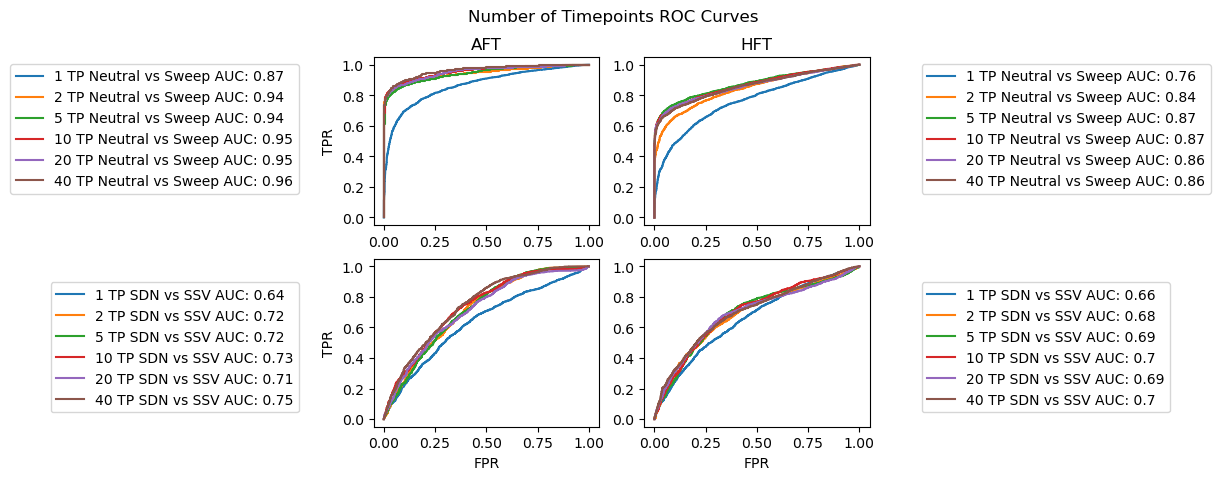

In [5]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/tps_vary"
nums = [1, 2, 5, 10, 20, 40]
names = [f"{i}_tp" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/{name}_sims/test_predictions/{num}_Timepoint_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"{num} TP Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"{num} TP SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")
    
axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Number of Timepoints ROC Curves")
plt.savefig("num_tps_roc.pdf", bbox_inches="tight")

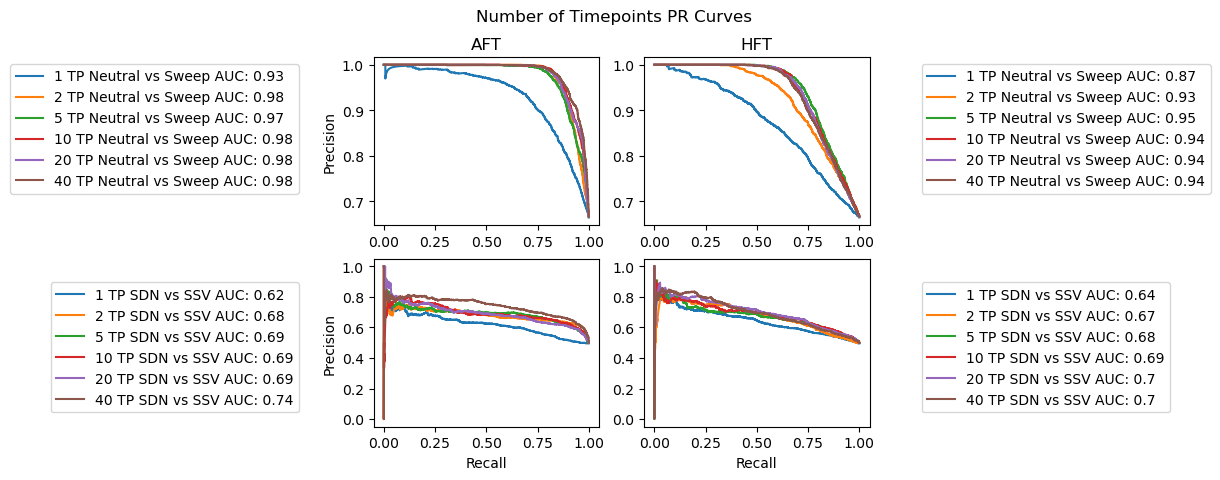

In [7]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/tps_vary"
nums = [1, 2, 5, 10, 20, 40]
names = [f"{i}_tp" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        df = pd.read_csv(f"{idir}/{name}/{name}_sims/test_predictions/{num}_Timepoint_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"{num} TP Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"{num} TP SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Number of Timepoints PR Curves")
plt.savefig("num_tps_pr.pdf", bbox_inches="tight")

1
3
11
51
101
1
3
11
51
101


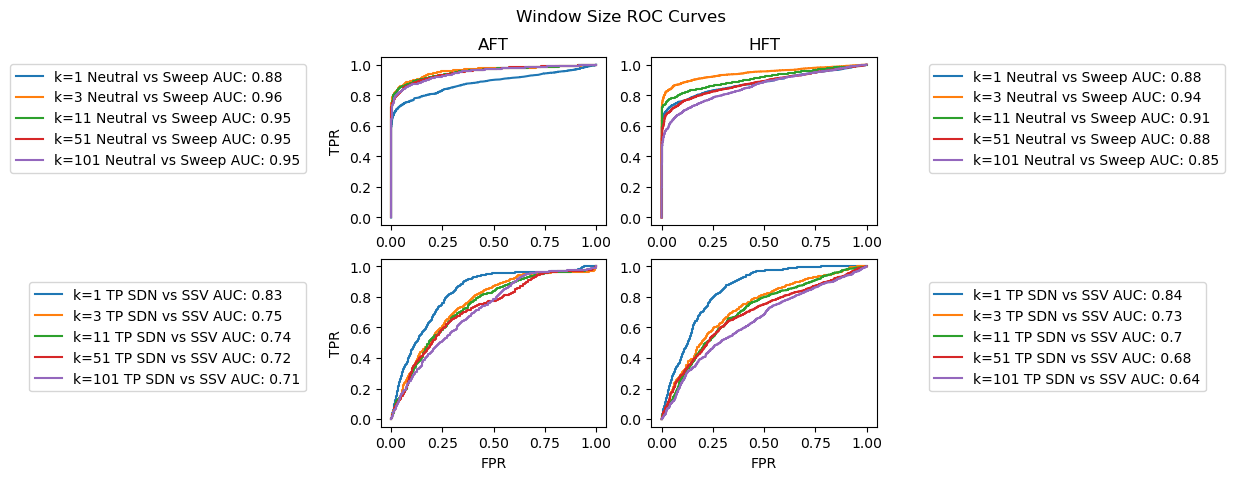

In [49]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/win_sizes"
nums = [1, 3, 11, 51, 101]
names = [f"k{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        print(num)
        df = pd.read_csv(f"{idir}/k51/win_size_sims/test_predictions/Win_size_{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        fpr, tpr, auc_val, swp_fpr, swp_tpr, swp_auc_val = get_roc(df)
        axes[0, di].plot(fpr, tpr, label=f"k={num} Neutral vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_fpr, swp_tpr, label=f"k={num} TP SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("TPR")
    axes[1, i].set_xlabel("FPR")
    
axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Window Size ROC Curves")
plt.savefig("win_size_roc.pdf", bbox_inches="tight")

1
3
11
51
101
1
3
11
51
101


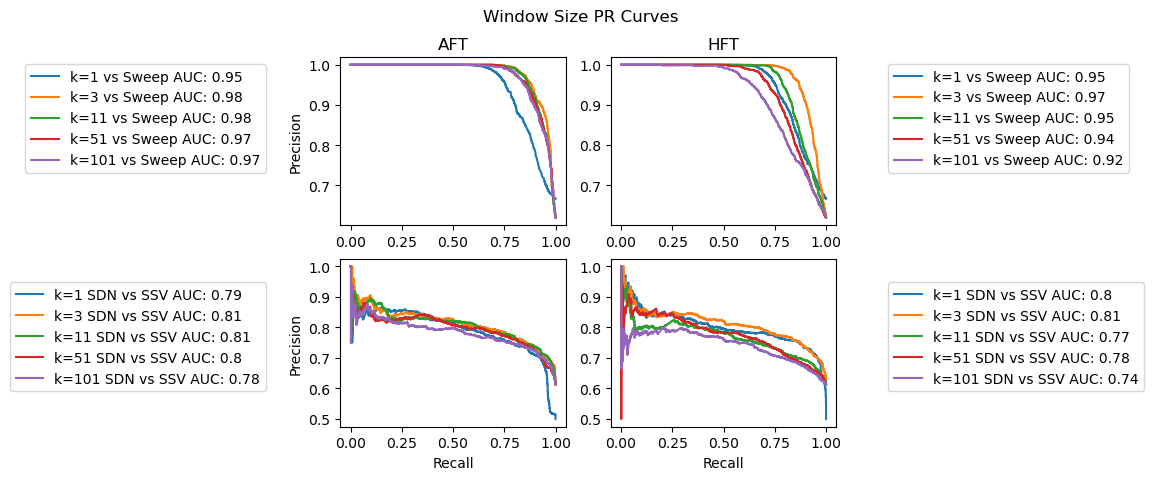

In [50]:
idir = "/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/win_sizes"
nums = [1, 3, 11, 51, 101]
names = [f"k{i}" for i in nums]

fig, axes = plt.subplots(2, 2)
for di, dtype in enumerate(["aft", "hft"]):
    for name, num in zip(names, nums):
        print(num)
        df = pd.read_csv(f"{idir}/k51/win_size_sims/test_predictions/Win_size_{num}_Timesweeper_Class_{dtype}_class_test_predictions.csv")
        df["int_true"] = [lab_dict[i] for i in df["true"]]
        prec, rec, auc_val, swp_prec, swp_rec, swp_auc_val = get_prec_recall(df)
        axes[0, di].plot(rec, prec, label=f"k={num} vs Sweep AUC: {auc_val:.2}")
        axes[1, di].plot(swp_rec, swp_prec, label=f"k={num} SDN vs SSV AUC: {swp_auc_val:.2}")
        
for i in range(2):
    axes[i, 0].set_ylabel("Precision")
    axes[1, i].set_xlabel("Recall")

axes[0, 0].set_title("AFT")    
axes[0, 1].set_title("HFT")    

axes[0, 0].legend(bbox_to_anchor=(-.3, 1))
axes[1, 0].legend(bbox_to_anchor=(-.3, 0.9))
axes[0, 1].legend(bbox_to_anchor=(1.2, 1))
axes[1, 1].legend(bbox_to_anchor=(1.2, 0.9))

plt.suptitle("Window Size PR Curves")
plt.savefig("win_size_pr.pdf", bbox_inches="tight")